In [23]:
import csv 
import os 
import math 
import numpy as np
from datetime import datetime
dpath = 'datasets/preprocessed/'
file_name = 'A146020302.csv'

#Makes the time a continuous value to work with ESN.
def time_linearisation(date): 
    format_code = "%Y%m%d"
    dt = datetime.strptime(date, format_code)

    # Week day
    dow = dt.weekday()
    dow_sin = math.sin(2 * math.pi * dow / 7)
    dow_cos = math.cos(2 * math.pi * dow / 7)

    # Month day
    dom = dt.day - 1
    days_in_month = 31  # number of days in a month approximation
    dom_sin = math.sin(2 * math.pi * dom / days_in_month)
    dom_cos = math.cos(2 * math.pi * dom / days_in_month)

    # Day of Year
    doy = dt.timetuple().tm_yday - 1
    days_in_year = 365.25  # number of days in a year approximation
    doy_sin = math.sin(2 * math.pi * doy / days_in_year)
    doy_cos = math.cos(2 * math.pi * doy / days_in_year)

    # Months
    month = dt.month - 1
    month_sin = math.sin(2 * math.pi * month / 12)
    month_cos = math.cos(2 * math.pi * month / 12)

    return np.array([
        doy_sin, doy_cos,
    ])

print(time_linearisation("20230630"))  # Example usage


[ 0.04514102 -0.99898062]


In [24]:
# Load preprocessed data

# inputs : Qls (1), Qmmj (2), Ptot (9), Fsol(10), Temp (11), E_ou (12), E_PE (13), E_PM (14), Vent (15), Humi (16), Dli (17), SSI (18), IHGR (19), TN (22), TX (23), niveau_deau (24)

def load_X_Y(filepath):
    X = []
    inputs_columns = [ 1, 2,9,16,24 ]
    with open(filepath, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if not row or row[0].startswith("D"):
                continue
            time_features = time_linearisation(row[0])
            X.append(np.concatenate([time_features] + [[float(row[i])] for i in inputs_columns]))
        return np.array(X)


In [25]:
import matplotlib.pyplot as plt 
def plot_results(y_pred, y_test, sample=800):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(np.arange(sample), y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(np.arange(sample), y_test[:sample], linestyle="--", lw=2, label="True value")
   # plt.plot(np.abs(y_test[:sample] - y_pred[:sample]), label="Absolute deviation")

    plt.legend()
    plt.show()

In [26]:
from reservoirpy.datasets import to_forecasting
def normalize_data(data):
    # Normalizing data between 0 and 1 column by column
    min_vals = data.min(axis=0)
    max_vals = data.max(axis=0)
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    return normalized_data, min_vals, max_vals

data = load_X_Y(dpath + file_name)
data, min_vals, max_vals = normalize_data(data)
x,y= to_forecasting(data[3156:], forecast=7)
print(x.shape, y.shape)
y = y[:, -1].reshape(-1, 1) # chosing the data that will be used (electricity consuption)
units = 1500 
leak_rate = 0.7503908723453986
spectral_radius = 0.12438215679394352
input_scaling = .7
connectivity = 0.6
input_connectivity = 0.3
regularization = 1e-1
seed = 42
X_train1, y_train1 = x[:2000], y[:2000]
X_test1, y_test1 = x[2000:], y[2000:]
X_test1 = np.asarray(X_test1) # chosing the data that will be used (electricity consuption)
X_test1 = X_test1.reshape(X_test1.shape[0], -1) # reshaping data that they could be used by reservoir py
# plot_train_test(X_train1, y_train1, X_test1, y_test1)


(7494, 7) (7494, 7)


In [27]:
from reservoirpy.nodes import Ridge
from reservoirpy.nodes import Reservoir 
reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(9.102910091122064)


esn_online = reservoir >> readout

In [28]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(ridge=regularization, output_dim=1) #10 size of the entry vector 

    return reservoir >> readout


In [29]:

from reservoirpy.nodes import Reservoir, Ridge
reset_esn()

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

readout   = Ridge(ridge=regularization, output_dim=1)

esn = reservoir >> readout


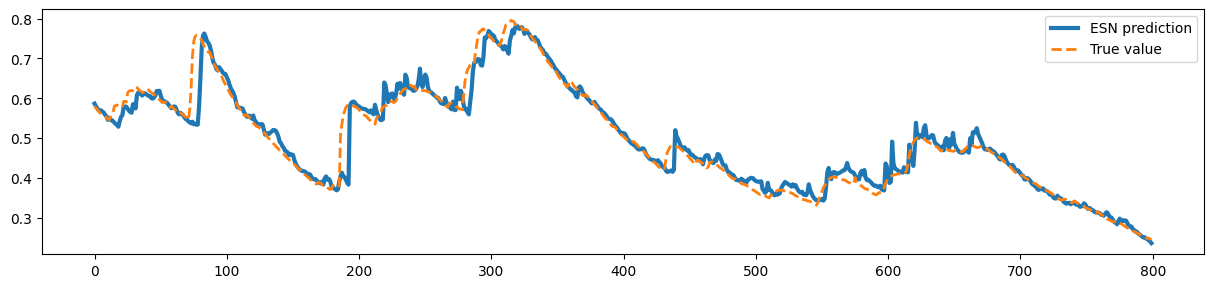

In [30]:
esn = esn.fit(X_train1, y_train1)
y_pred1 = esn.run(X_test1)
plot_results(y_pred1, y_test1)
#y_pred = esn.run(X_train1)
#plot_results(y_pred, y_train1)

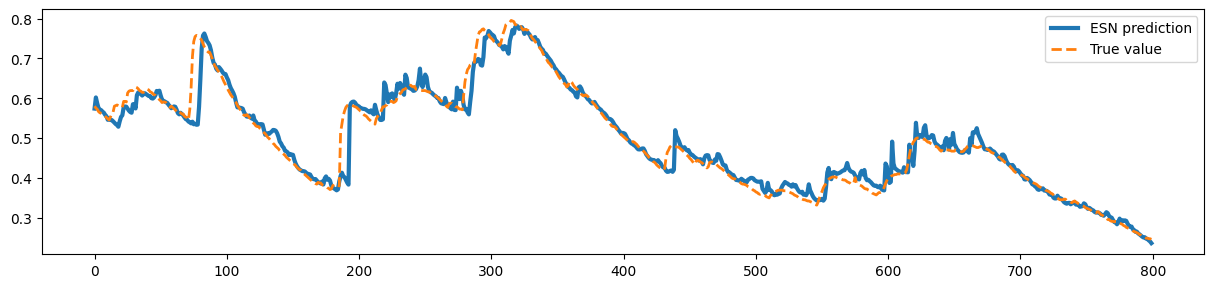

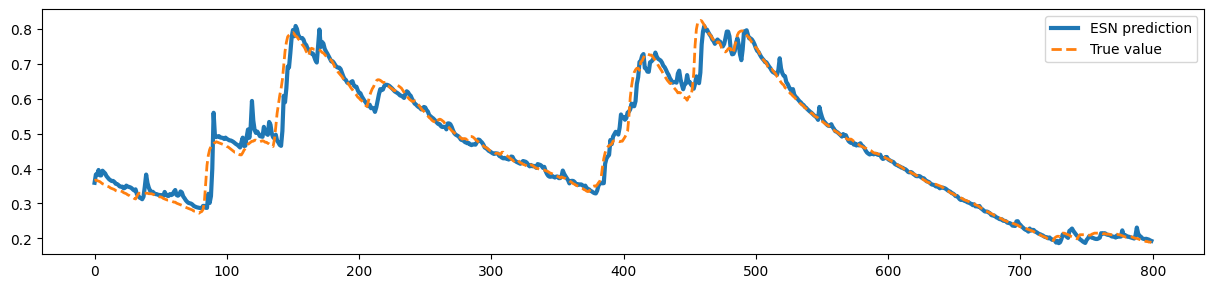

In [ ]:
y_pred1 = esn.run(X_test1)
plot_results(y_pred1, y_test1)

In [32]:
import json

hyperopt_config = {
    "exp": "hyperopt-ridge",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [33]:
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Ridge

In [34]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result of the loss function.
# You can add any additional metrics or information with other keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [35]:
train_len = 2000
forecast = 14

X_train = x[:train_len]
Y_train = x[forecast : train_len + forecast]

X_test = x[train_len : -forecast]
Y_test = x[train_len + forecast:]

dataset = (X_train, X_test, Y_train, Y_test)

In [36]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(x, forecast=forecast, test_size=train_len-forecast)

In [37]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

 10%|█         | 20/200 [00:04<00:41,  4.31trial/s, best loss=0.0594]


KeyboardInterrupt: 

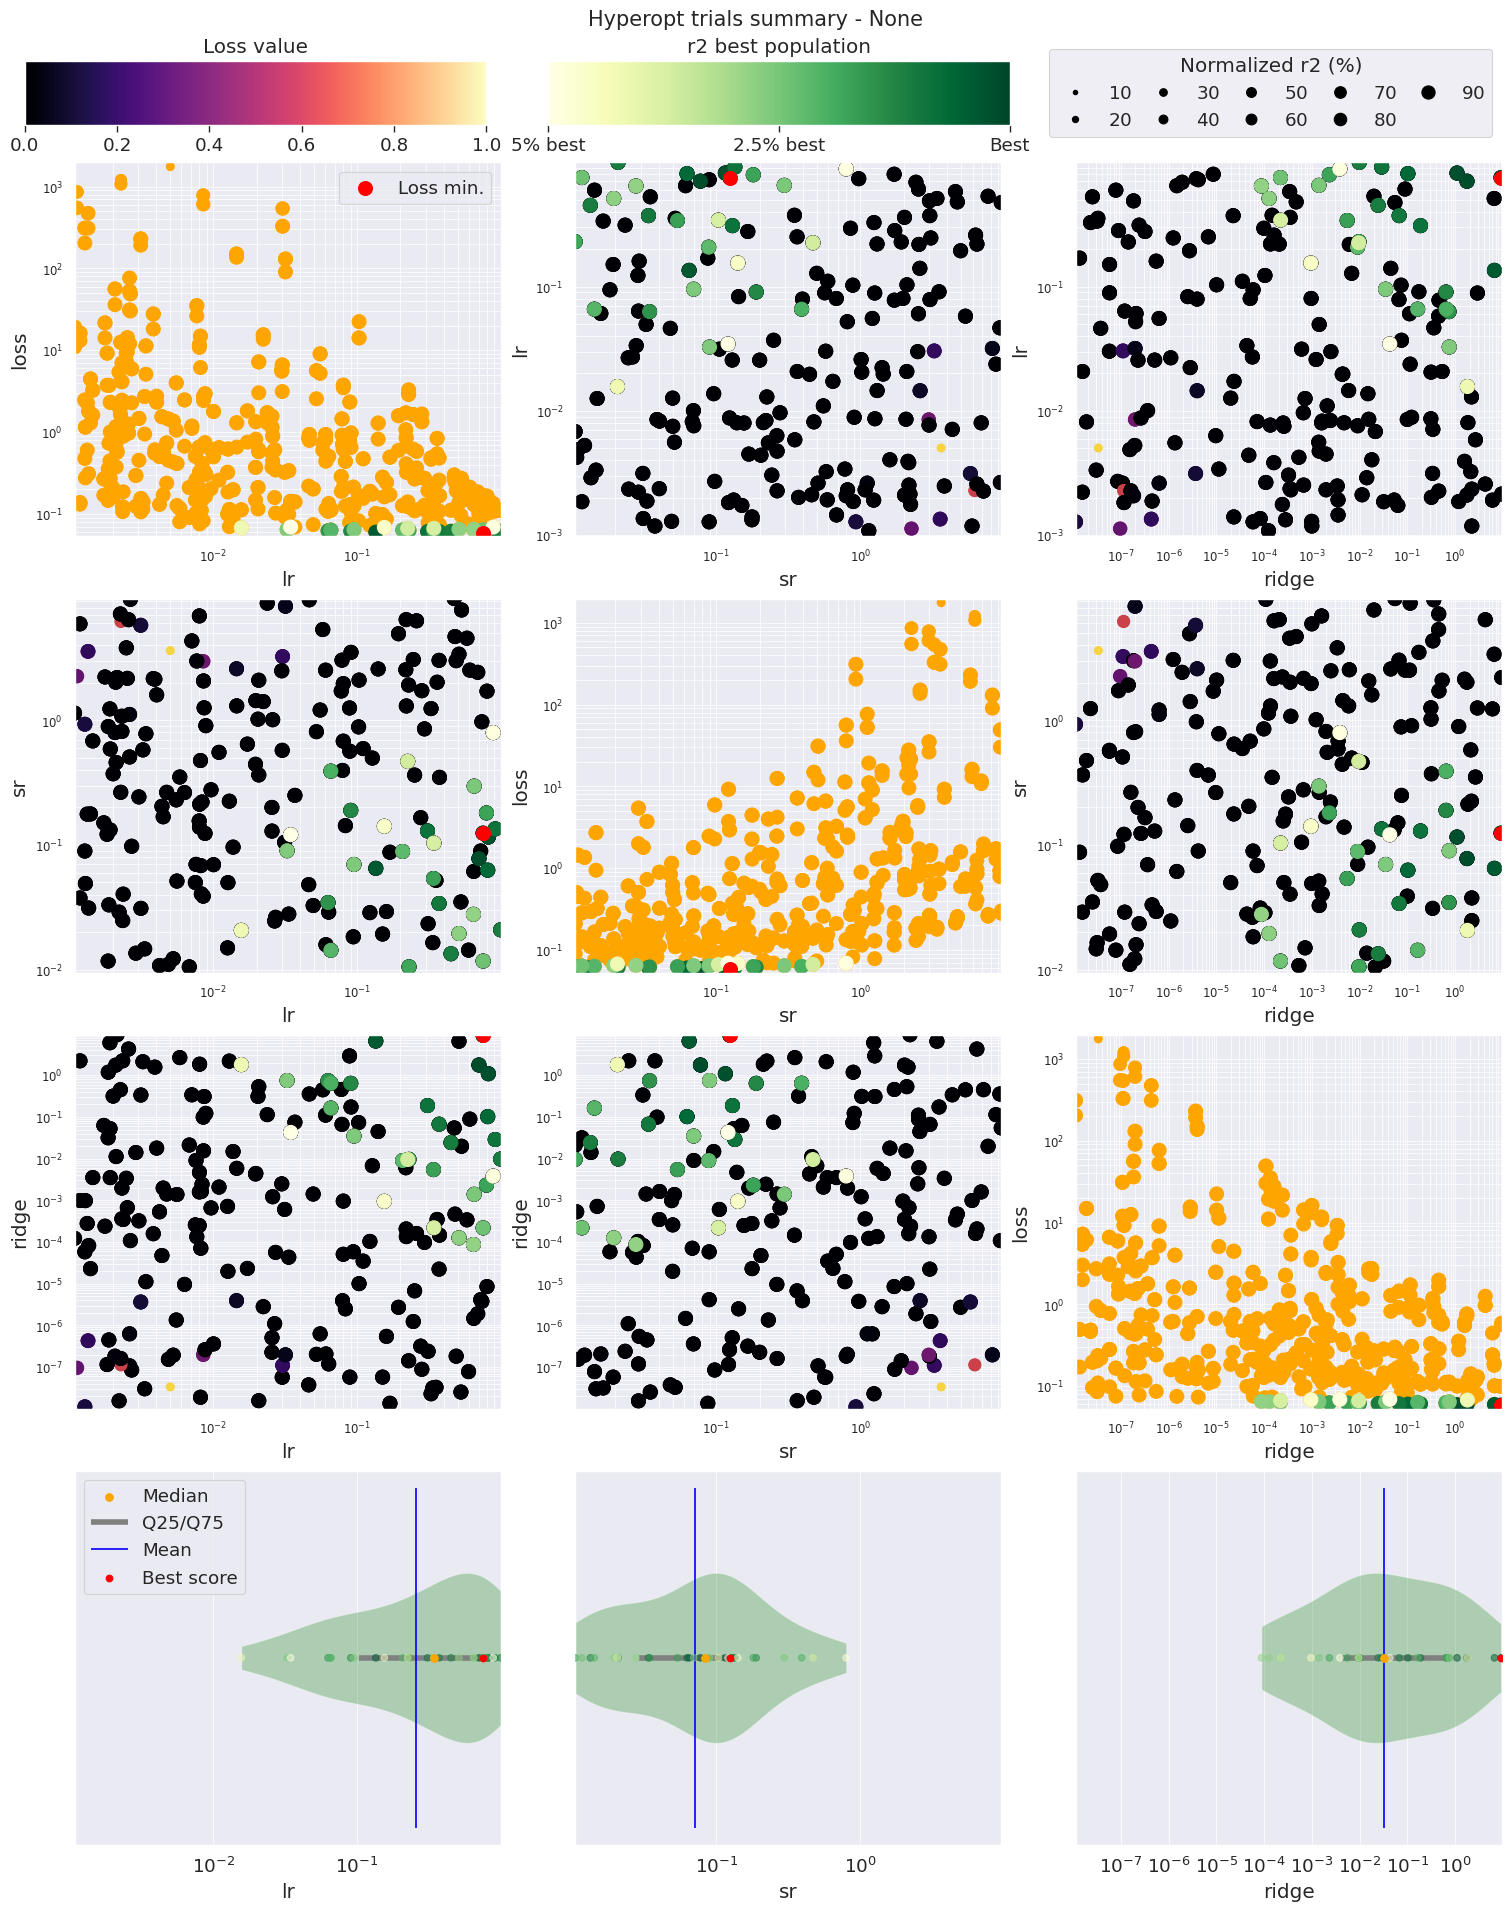

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr" , "sr", "ridge"), metric="r2")

In [ ]:
hyperopt_config = {
    "exp": "hyperopt-ridge-narrow",    # the experimentation name
    "hp_max_evals": 100,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 1],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-1, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-2, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 100/100 [00:17<00:00,  5.78trial/s, best loss=0.059]


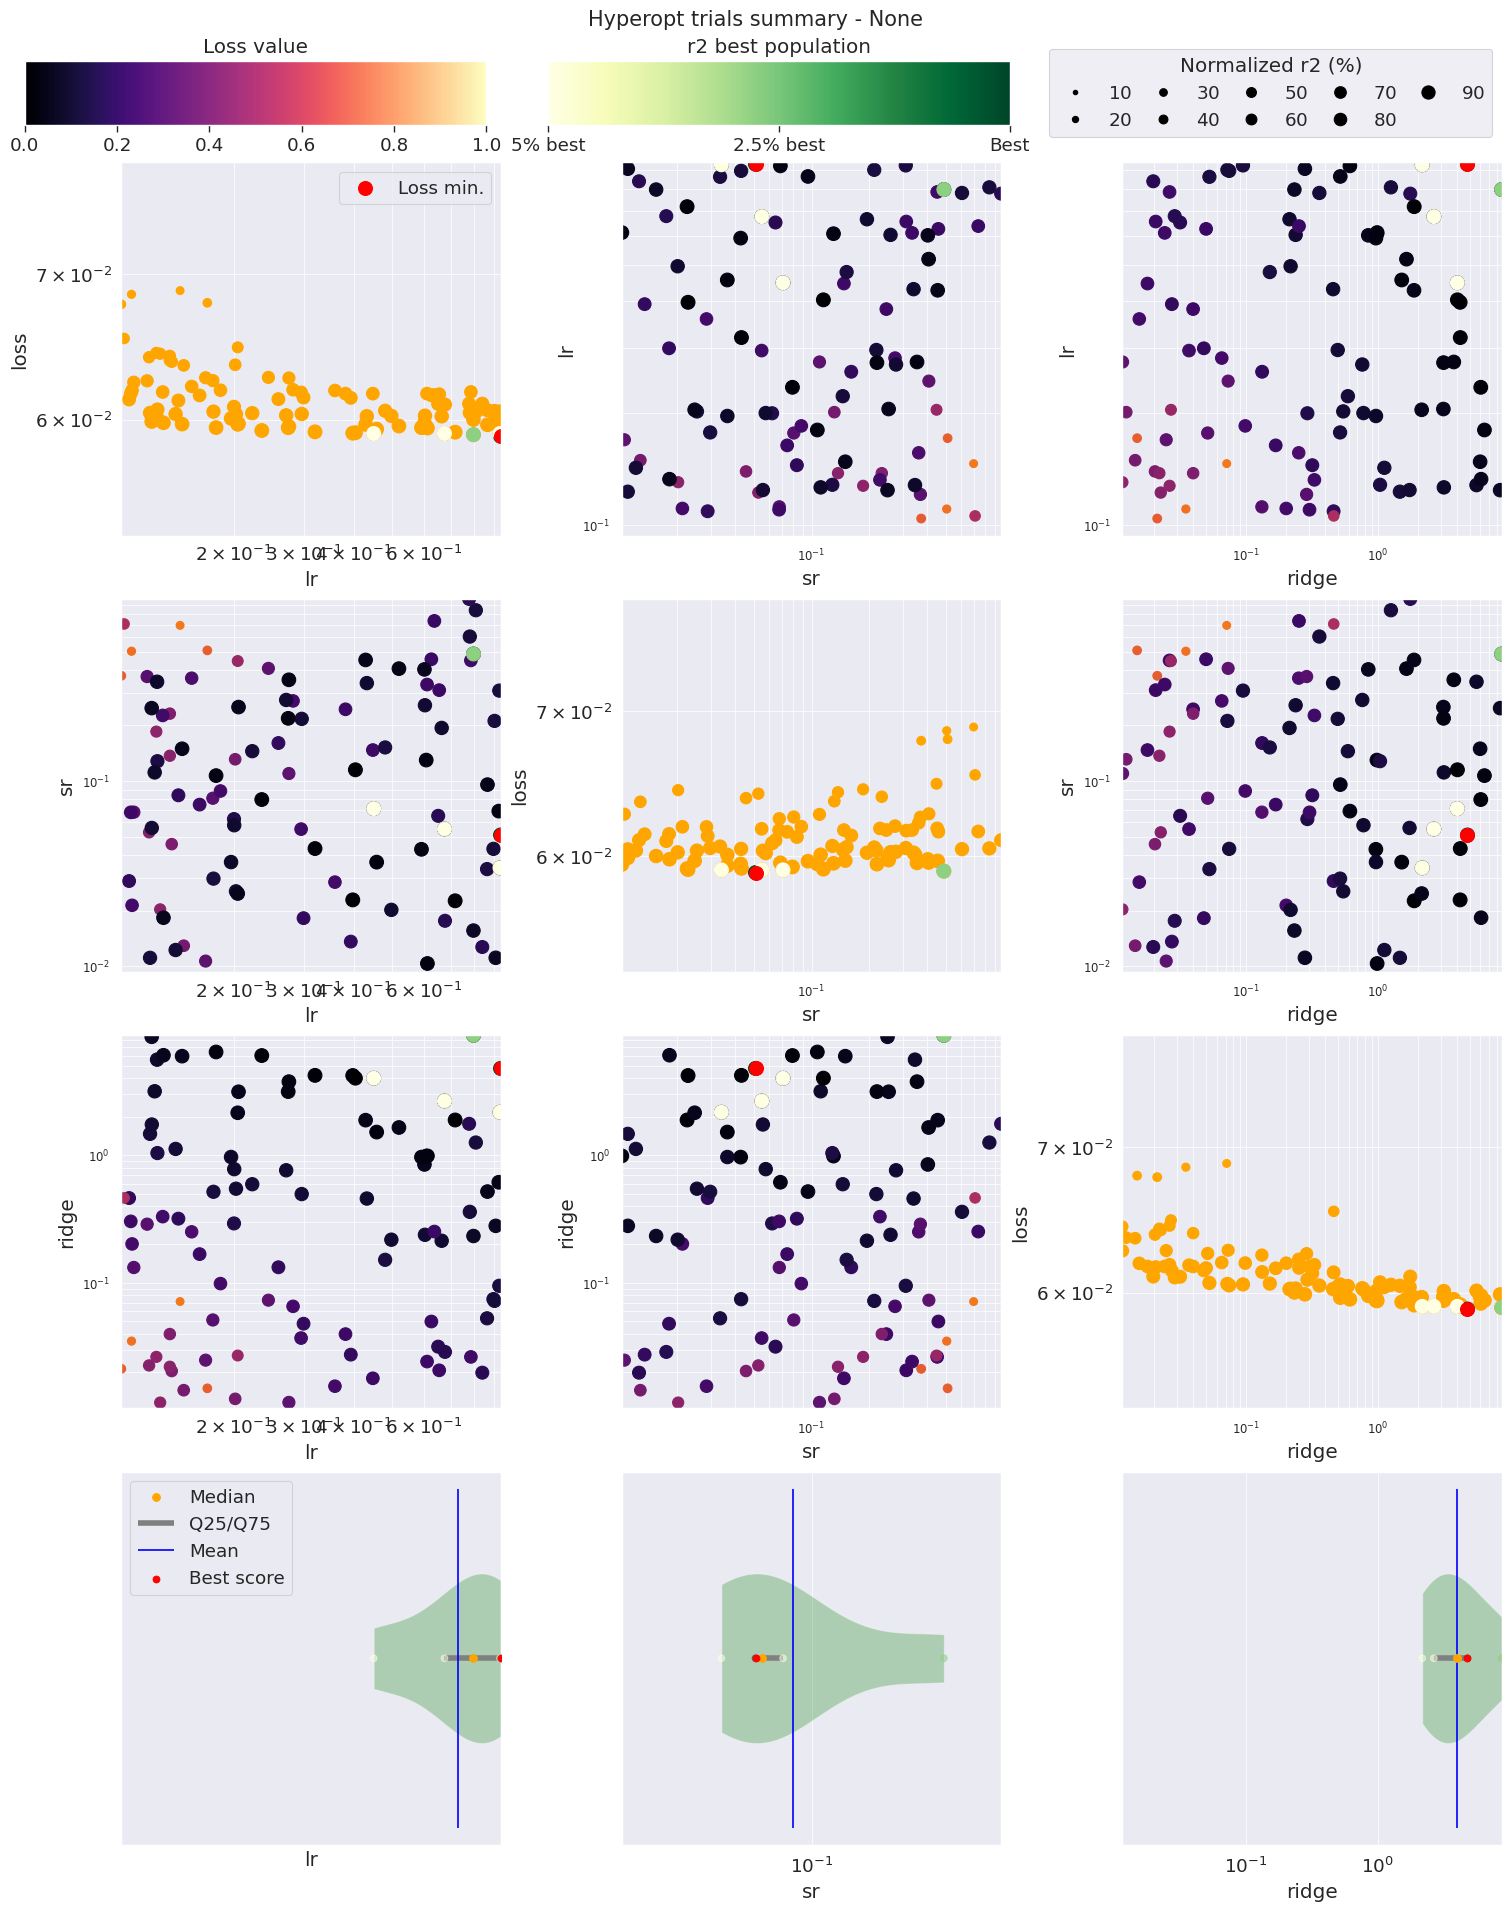

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr" , "sr", "ridge"), metric="r2")

In [ ]:
hyperopt_config = {
    "exp": "hyperopt-ridge-narrow2",    # the experimentation name
    "hp_max_evals": 50,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 5e-2, 8e-1],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 5e-1, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 5e-2, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 50/50 [00:08<00:00,  5.80trial/s, best loss=0.0589]


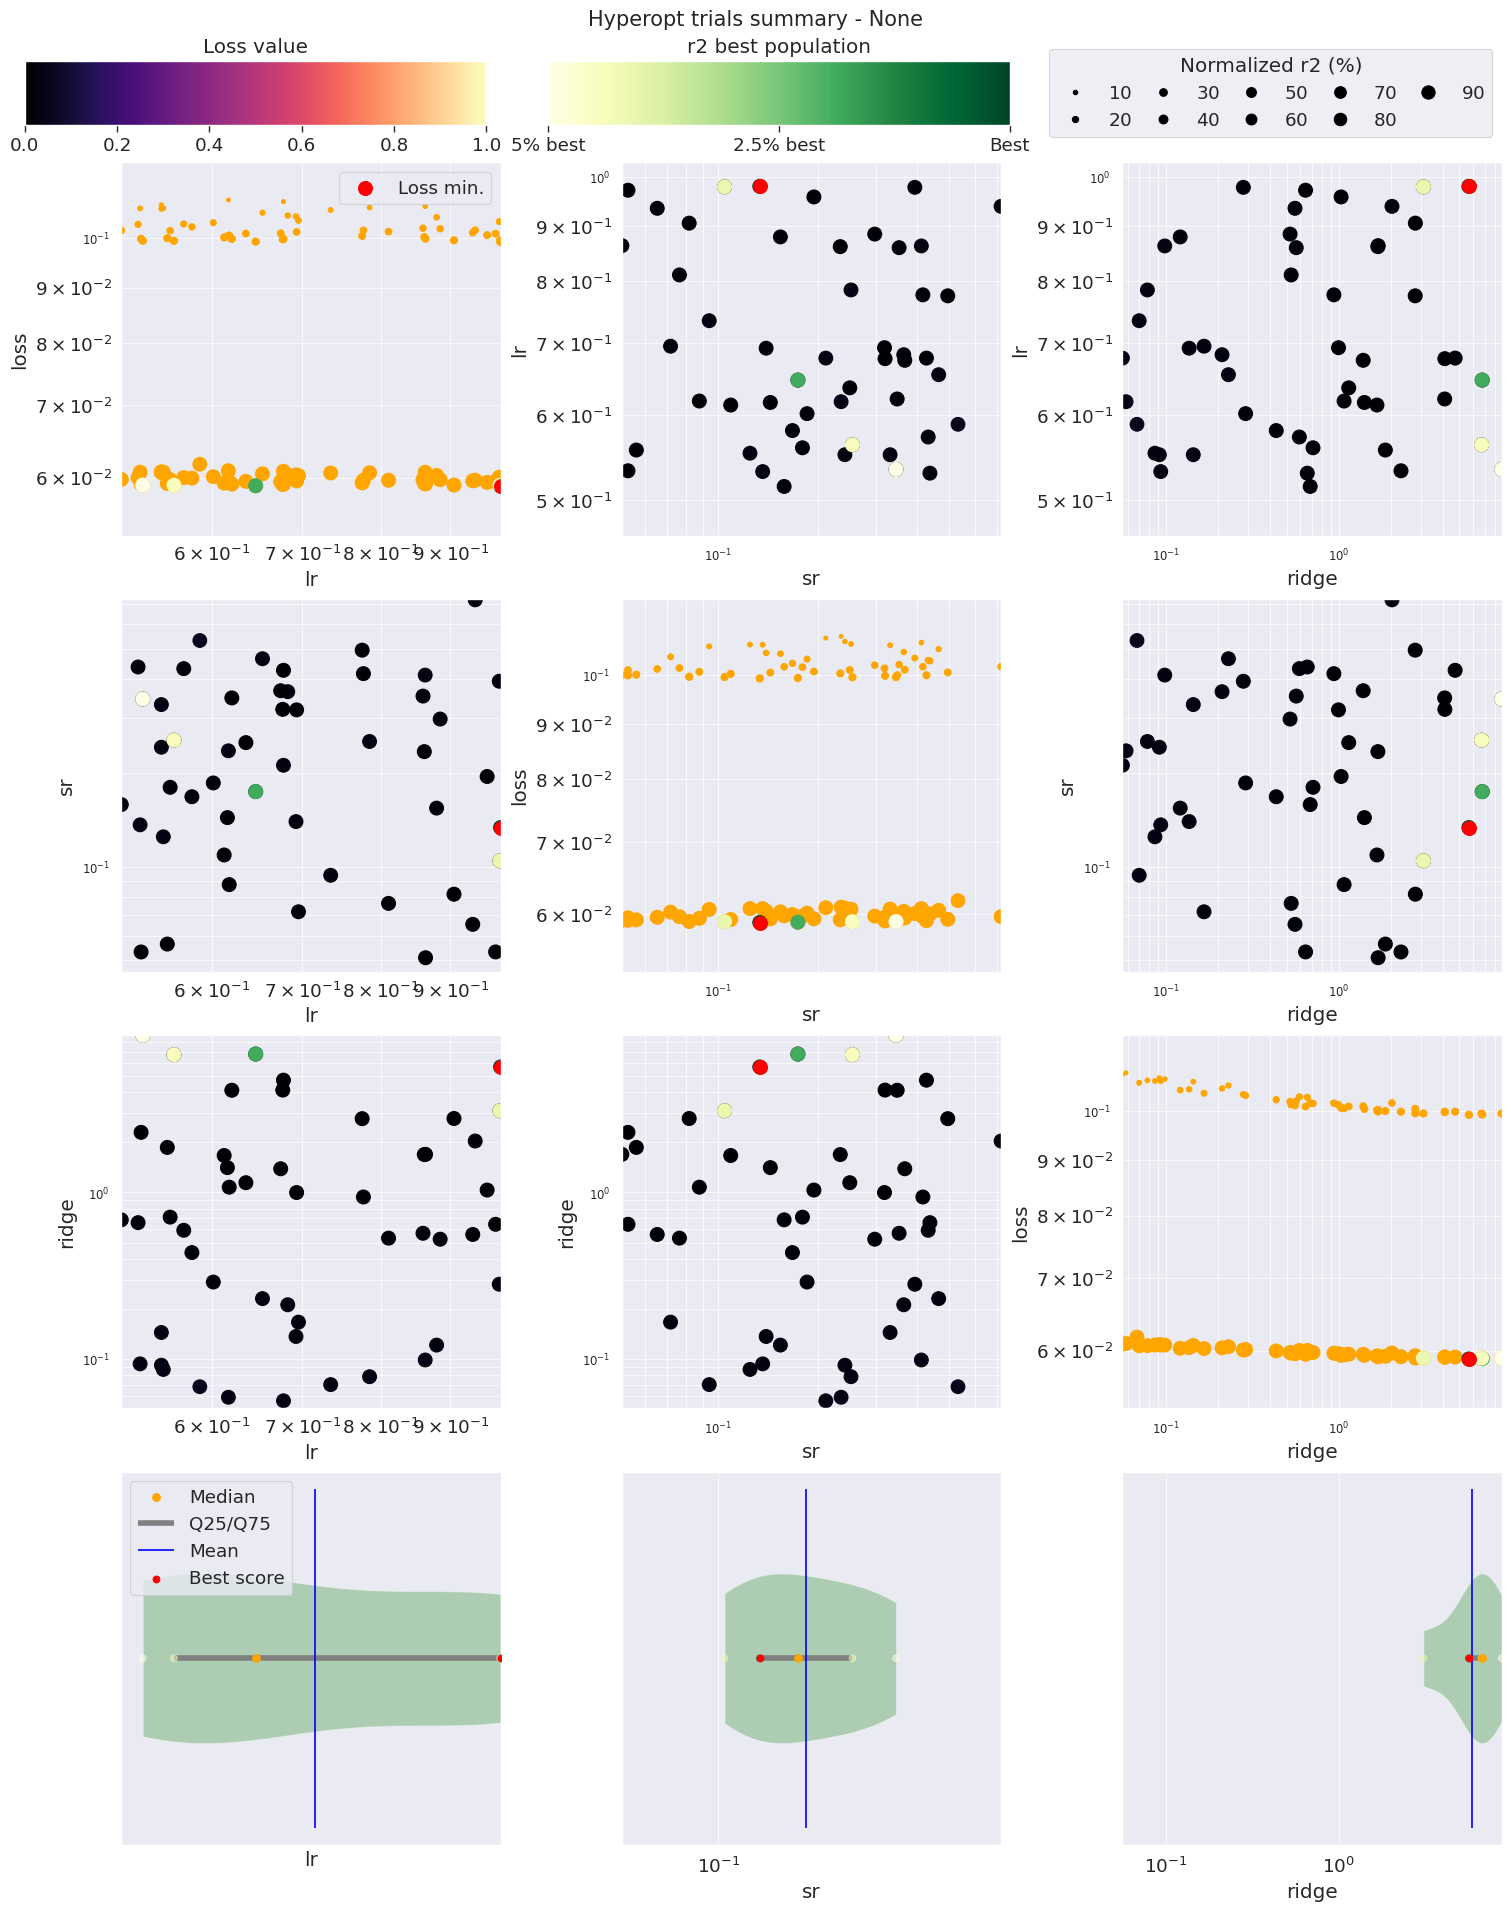

In [ ]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr" , "sr", "ridge"), metric="r2")